# Get Flowers102 Dataset With Caption

Text-to-Image Synthesis resources
- [Original repo](https://github1s.com/reedscot/icml2016)
- [Example repo](https://github1s.com/aelnouby/Text-to-Image-Synthesis/tree/master/images)
    - Download Flowers102 [here](https://drive.google.com/file/d/1EgnaTrlHGaqK5CCgHKLclZMT_AMSTyh8/view)
- The [paper](https://arxiv.org/pdf/1605.05395.pdf) that first published the annotated Flower102 dataset

Please perform the following steps to correctly download the dataset.

1. Create a `./data` directory under the root directory of this repo. Run `mkdir data && cd ./data`
2. Goto [this repo](https://github1s.com/aelnouby/Text-to-Image-Synthesis/tree/master/images), examine its README.md, then proceed to the [download link](https://drive.google.com/file/d/1EgnaTrlHGaqK5CCgHKLclZMT_AMSTyh8/view)
3. Verify the file is successfully downloaded, and resides in `./data/flowers.hdf5`
4. Install [h5py](https://pypi.org/project/h5py/) using `pip install h5py`

## 1 Examine Items in Flowers.hdf5

In [11]:
import io, h5py, torch, numpy as np
from PIL import Image

''' 1. Get familiar with the hdf5 structure '''

file = h5py.File('./data/flowers.hdf5', 'r')

for split in ['train', 'valid', 'test']:
    ds_keys = [str(key) for key in file[split].keys()] 
    print(f'The [{split}] set has [{len(ds_keys)}] images, e.g. {ds_keys[:3]} ...')


ds_keys = [str(key) for key in file['train'].keys()]
item = file['train'][ds_keys[0]]
item_keys = item.keys()
print(f'\nEach image item has {len(item_keys)} keys: {item_keys}. ')

class_ = item['class']
embeddings = item['embeddings']
image = item['img']
name = item['name']
caption = item['txt']

image_processed = Image.open(io.BytesIO(bytes(np.array(image)))).resize((64, 64))
embeddings_processed = torch.FloatTensor(np.array(embeddings, dtype=float))
name_processed = np.array(name).astype(str)
class_processed = np.array(class_).astype(str)
caption_processed = np.array(caption).astype(str)

print(f'Each item is of the same type: {type(image)}, which needs additional processing to be usable.')
print(f'After processing we have:')
print(f'\tImage with name [{name_processed}] and class [{class_processed}]  of size {image_processed.size}')
print(f'\tEmbedding of shape {embeddings_processed.shape}')
print(f'\tImage caption: {caption_processed}')


image_processed.show()
image_processed.save('foo.png')

The [train] set has [29390] images, e.g. ['image_00001_0', 'image_00001_1', 'image_00001_2'] ...
The [valid] set has [5780] images, e.g. ['image_03369_0', 'image_03369_1', 'image_03369_2'] ...
The [test] set has [5775] images, e.g. ['image_03095_0', 'image_03095_1', 'image_03095_2'] ...

Each image item has 5 keys: <KeysViewHDF5 ['class', 'embeddings', 'img', 'name', 'txt']>. 
Each item is of the same type: <class 'h5py._hl.dataset.Dataset'>, which needs additional processing to be usable.
After processing we have:
	Image with name [image_00001] and class [class_00077]  of size (64, 64)
	Embedding of shape torch.Size([1024])
	Image caption: prominent purple stigma,petals are white inc olor




(eog:150075): Gtk-WARNING **: 11:56:11.856: cannot open display: 


In [1]:
from dataset import *

''' 2. Get familiar with images, caption_embedding, captions 
    ref: https://github1s.com/aelnouby/Text-to-Image-Synthesis/blob/master/txt2image_dataset.py#L1-L11
'''

dataset = Flowers102('./data/flowers.hdf5')

item = dataset.__getitem__(0)
right_images = item['right_images']
right_embed = item['right_embed']
wrong_images = item['wrong_images']
inter_embed = item['inter_embed']
txt = item['txt']
print(f'There are 5 keys in each item: [{item.keys()}]')

There are 5 keys in each item: [dict_keys(['right_images', 'right_embed', 'wrong_images', 'inter_embed', 'txt'])]


## 2 Define GAN_CLS Model

  0%|          | 0/100 [00:00<?, ?it/s]

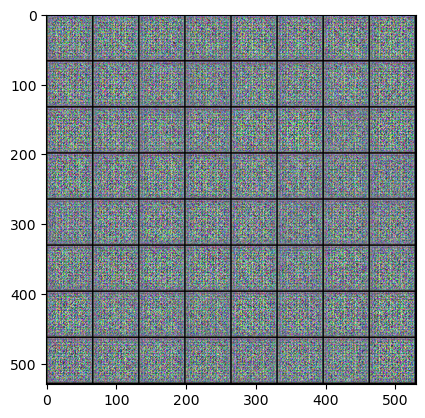

 20%|██        | 20/100 [00:14<00:55,  1.44it/s]

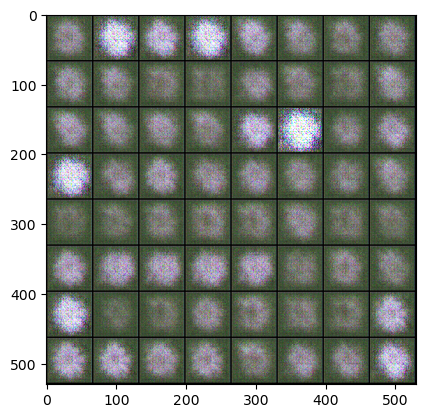

 40%|████      | 40/100 [00:28<00:41,  1.45it/s]

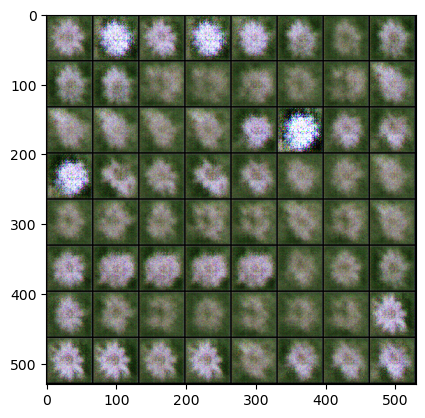

 60%|██████    | 60/100 [00:42<00:27,  1.44it/s]

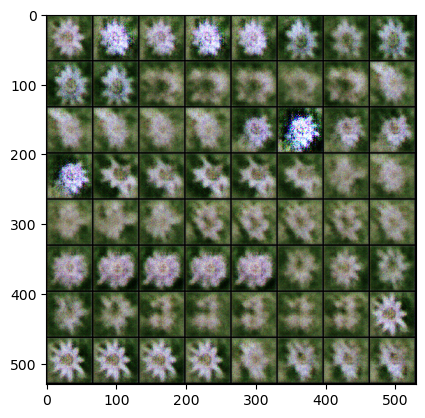

 80%|████████  | 80/100 [00:56<00:13,  1.44it/s]

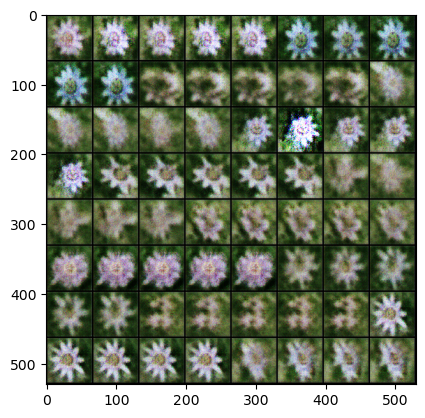

100%|██████████| 100/100 [01:10<00:00,  1.43it/s]


In [1]:
from dataset import *
from utils import *
from tqdm import tqdm

import torch, torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

class generator(nn.Module):
	def __init__(self):
		super(generator, self).__init__()
		self.image_size = 64
		self.num_channels = 3
		self.noise_dim = 100
		self.embed_dim = 1024
		self.projected_embed_dim = 128
		self.latent_dim = self.noise_dim + self.projected_embed_dim
		self.ngf = 64

		self.projection = nn.Sequential(
			nn.Linear(in_features=self.embed_dim, out_features=self.projected_embed_dim),
			nn.BatchNorm1d(num_features=self.projected_embed_dim),
			nn.LeakyReLU(negative_slope=0.2, inplace=True)
			)

		# based on: https://github.com/pytorch/examples/blob/master/dcgan/main.py
		self.netG = nn.Sequential(
			nn.ConvTranspose2d(self.latent_dim, self.ngf * 8, 4, 1, 0, bias=False),
			nn.BatchNorm2d(self.ngf * 8),
			nn.ReLU(True),
			# state size. (ngf*8) x 4 x 4
			nn.ConvTranspose2d(self.ngf * 8, self.ngf * 4, 4, 2, 1, bias=False),
			nn.BatchNorm2d(self.ngf * 4),
			nn.ReLU(True),
			# state size. (ngf*4) x 8 x 8
			nn.ConvTranspose2d(self.ngf * 4, self.ngf * 2, 4, 2, 1, bias=False),
			nn.BatchNorm2d(self.ngf * 2),
			nn.ReLU(True),
			# state size. (ngf*2) x 16 x 16
			nn.ConvTranspose2d(self.ngf * 2,self.ngf, 4, 2, 1, bias=False),
			nn.BatchNorm2d(self.ngf),
			nn.ReLU(True),
			# state size. (ngf) x 32 x 32
			nn.ConvTranspose2d(self.ngf, self.num_channels, 4, 2, 1, bias=False),
			nn.Tanh()
			 # state size. (num_channels) x 64 x 64
			)


	def forward(self, embed_vector, z):

		projected_embed = self.projection(embed_vector).unsqueeze(2).unsqueeze(3)
		latent_vector = torch.cat([projected_embed, z], 1)
		output = self.netG(latent_vector)

		return output

class discriminator(nn.Module):
	def __init__(self):
		super(discriminator, self).__init__()
		self.image_size = 64
		self.num_channels = 3
		self.embed_dim = 1024
		self.projected_embed_dim = 128
		self.ndf = 64
		self.B_dim = 128
		self.C_dim = 16

		self.netD_1 = nn.Sequential(
			# input is (nc) x 64 x 64
			nn.Conv2d(self.num_channels, self.ndf, 4, 2, 1, bias=False),
			nn.LeakyReLU(0.2, inplace=True),
			# state size. (ndf) x 32 x 32
			nn.Conv2d(self.ndf, self.ndf * 2, 4, 2, 1, bias=False),
			nn.BatchNorm2d(self.ndf * 2),
			nn.LeakyReLU(0.2, inplace=True),
			# state size. (ndf*2) x 16 x 16
			nn.Conv2d(self.ndf * 2, self.ndf * 4, 4, 2, 1, bias=False),
			nn.BatchNorm2d(self.ndf * 4),
			nn.LeakyReLU(0.2, inplace=True),
			# state size. (ndf*4) x 8 x 8
			nn.Conv2d(self.ndf * 4, self.ndf * 8, 4, 2, 1, bias=False),
			nn.BatchNorm2d(self.ndf * 8),
			nn.LeakyReLU(0.2, inplace=True),
		)

		self.projector = Concat_embed(self.embed_dim, self.projected_embed_dim)

		self.netD_2 = nn.Sequential(
			# state size. (ndf*8) x 4 x 4
			nn.Conv2d(self.ndf * 8 + self.projected_embed_dim, 1, 4, 1, 0, bias=False),
			nn.Sigmoid()
			)	

	def forward(self, inp, embed):
		x_intermediate = self.netD_1(inp)
		x = self.projector(x_intermediate, embed)
		x = self.netD_2(x)

		return x.view(-1, 1).squeeze(1) , x_intermediate

device = torch.device('cuda') if torch.cuda.is_available else torch.device('cpu')
config = {
    'epochs'      : 100  , 
    'noise_dim'   : 100   ,
    'batch_size'  : 64    ,
    'num_workers' : 4     ,
    'lr'          : 2e-4  ,
    'bz'          : 64    ,
    'beta1'       : 0.5   ,
    'DITER'       : 5     ,
    'l1_coef'     : 50    ,
    'l2_coef'     : 100   
}

transform = transforms.Compose([
                               transforms.Resize((64,64)),
                               transforms.CenterCrop((64,64)),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])

''' Criterions '''
criterion = nn.BCELoss()
l2_loss = nn.MSELoss()
l1_loss = nn.L1Loss()


''' Dataset and dataloader  TODO: Augmentation'''
dataset = Flowers102()
dataloader = DataLoader(dataset, batch_size=config['bz'], shuffle=False, num_workers=config['num_workers'])


''' Model '''
Generator = generator().to(device)
Discriminator = discriminator().to(device)

''' Optimizers '''
optimD = torch.optim.Adam(Generator.parameters(), lr=config['lr'], betas=(config['beta1'], 0.999))
optimG = torch.optim.Adam(Discriminator.parameters(), lr=config['lr'], betas=(config['beta1'], 0.999))


for epoch in (pbar:=tqdm(range(config['epochs']))):
    for batch in dataloader:
        ''' Training '''
        right_images = batch['right_images']
        right_embed = batch['right_embed']
        wrong_images = batch['wrong_images']

        right_images = Variable(right_images.float()).to(device)
        right_embed = Variable(right_embed.float()).to(device)
        wrong_images = Variable(wrong_images.float()).to(device)

        real_labels = torch.ones(right_images.size(0))
        fake_labels = torch.zeros(right_images.size(0))
        # TODO: understand this
        smoothed_real_labels = torch.FloatTensor(Utils.smooth_label(real_labels.numpy(), -0.1))

        real_labels = real_labels.to(device)
        fake_labels = fake_labels.to(device)
        smoothed_real_labels = smoothed_real_labels.to(device)

        # 1. Train discriminator
        Discriminator.zero_grad()
        outputs, activation_real = Discriminator(right_images, right_embed)
        real_loss = criterion(outputs, smoothed_real_labels)
        real_score = outputs

        outputs, _ = Discriminator(wrong_images, right_embed)   # Loss conditioned on CLS
        wrong_loss = criterion(outputs, fake_labels)
        wrong_score = outputs

        noise = Variable(torch.randn(right_images.size(0), 100)).to(device)
        noise = noise.view(noise.size(0), 100, 1, 1)
        fake_images = Generator(right_embed, noise)
        outputs, _ = Discriminator(fake_images, right_embed)
        fake_loss = criterion(outputs, fake_labels)
        fake_score = outputs
        d_loss = real_loss + fake_loss

        d_loss += wrong_loss       # Loss conditioned on CLS
        d_loss.backward()
        optimD.step()

        # 2. Train Generator
        Generator.zero_grad()
        noise = Variable(torch.randn(right_images.size(0), 100)).to(device)
        noise = noise.view(noise.size(0), 100, 1, 1)
        fake_images = Generator(right_embed, noise)
        outputs, activation_fake = Discriminator(fake_images, right_embed)
        _, activation_real = Discriminator(right_images, right_embed)

        activation_fake = torch.mean(activation_fake, 0)
        activation_real = torch.mean(activation_real, 0)

        #======= Generator Loss function============
        # This is a customized loss function, the first term is the regular cross entropy loss
        # The second term is feature matching loss, this measure the distance between the real and generated
        # images statistics by comparing intermediate layers activations
        # The third term is L1 distance between the generated and real images, this is helpful for the conditional case
        # because it links the embedding feature vector directly to certain pixel values.
        #===========================================
        g_loss = criterion(outputs, real_labels) \
                    + config['l2_coef'] * l2_loss(activation_fake, activation_real.detach()) \
                    + config['l1_coef'] * l1_loss(fake_images, right_images)
        g_loss.backward()
        optimG.step()
    
    if epoch % 20 == 0:
        grid = make_grid(fake_images, nrow=8, normalize=True).cpu()
        plt.imshow(grid.permute(1,2,0))
        plt.show()

## TODOs